In [1]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"


# Make sure we are able to handle large datasets
import resource

low, high = resource.getrlimit(resource.RLIMIT_NOFILE)
resource.setrlimit(resource.RLIMIT_NOFILE, (high, high))

import math
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds

import keras
from keras import ops
from keras import layers

2025-10-21 14:19:39.074321: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Dataset hyperparameters
unlabeled_dataset_size = 100000
labeled_dataset_size = 5000
image_channels = 3

# Algorithm hyperparameters
num_epochs = 20
batch_size = 525  # Corresponds to 200 steps per epoch
width = 128
temperature = 0.1
# Stronger augmentations for contrastive, weaker ones for supervised training
contrastive_augmentation = {"min_area": 0.25, "brightness": 0.6, "jitter": 0.2}
classification_augmentation = {
    "min_area": 0.75,
    "brightness": 0.3,
    "jitter": 0.1,
}

In [3]:
def prepare_dataset():
    # Labeled and unlabeled samples are loaded synchronously
    # with batch sizes selected accordingly
    steps_per_epoch = (unlabeled_dataset_size + labeled_dataset_size) // batch_size
    unlabeled_batch_size = unlabeled_dataset_size // steps_per_epoch
    labeled_batch_size = labeled_dataset_size // steps_per_epoch
    print(
        f"batch size is {unlabeled_batch_size} (unlabeled) + {labeled_batch_size} (labeled)"
    )

    # Turning off shuffle to lower resource usage
    unlabeled_train_dataset = (
        tfds.load("stl10", split="unlabelled", as_supervised=True, shuffle_files=False)
        .shuffle(buffer_size=10 * unlabeled_batch_size)
        .batch(unlabeled_batch_size)
    )
    labeled_train_dataset = (
        tfds.load("stl10", split="train", as_supervised=True, shuffle_files=False)
        .shuffle(buffer_size=10 * labeled_batch_size)
        .batch(labeled_batch_size)
    )
    test_dataset = (
        tfds.load("stl10", split="test", as_supervised=True)
        .batch(batch_size)
        .prefetch(buffer_size=tf.data.AUTOTUNE)
    )

    # Labeled and unlabeled datasets are zipped together
    train_dataset = tf.data.Dataset.zip(
        (unlabeled_train_dataset, labeled_train_dataset)
    ).prefetch(buffer_size=tf.data.AUTOTUNE)

    return train_dataset, labeled_train_dataset, test_dataset


# Load STL10 dataset
train_dataset, labeled_train_dataset, test_dataset = prepare_dataset()

batch size is 500 (unlabeled) + 25 (labeled)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

I0000 00:00:1761049534.853714    9658 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 8805 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:08:00.0, compute capability: 7.5


Shuffling /home/xy/tensorflow_datasets/stl10/incomplete.K0AHEJ_1.0.0/stl10-train.tfrecord*...:   0%|          …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /home/xy/tensorflow_datasets/stl10/incomplete.K0AHEJ_1.0.0/stl10-test.tfrecord*...:   0%|          |…

Generating unlabelled examples...: 0 examples [00:00, ? examples/s]

Shuffling /home/xy/tensorflow_datasets/stl10/incomplete.K0AHEJ_1.0.0/stl10-unlabelled.tfrecord*...:   0%|     …

Dataset stl10 downloaded and prepared to /home/xy/tensorflow_datasets/stl10/1.0.0. Subsequent calls will reuse this data.


2025-10-21 14:28:06.943926: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:396] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608


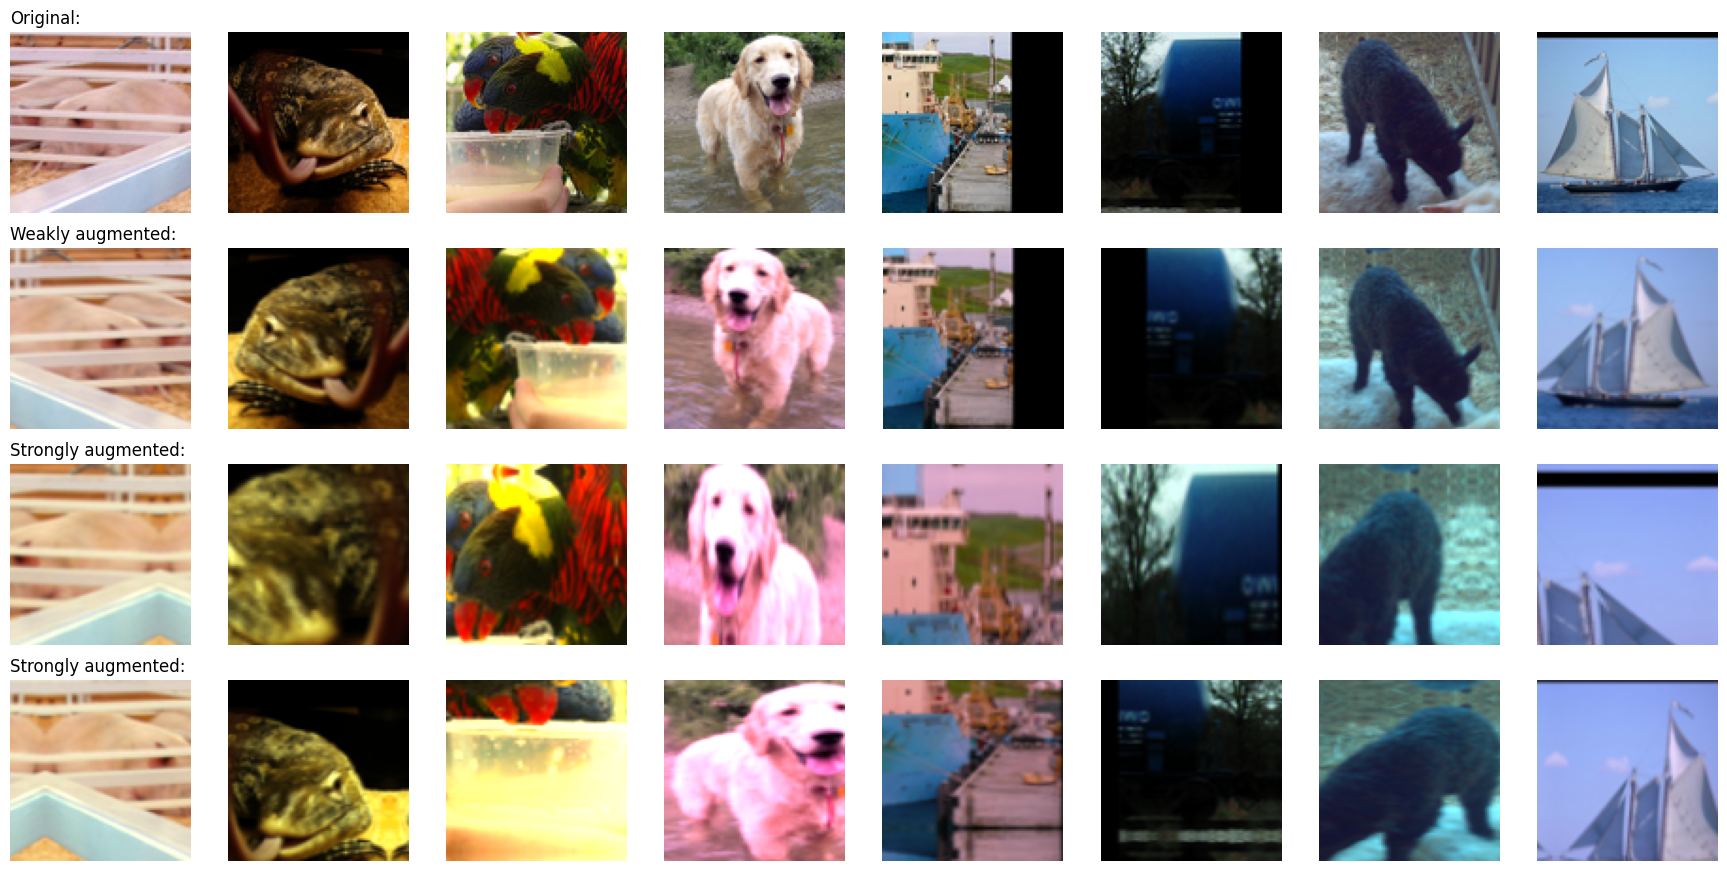

In [4]:
# Distorts the color distibutions of images
class RandomColorAffine(layers.Layer):
    def __init__(self, brightness=0, jitter=0, **kwargs):
        super().__init__(**kwargs)

        self.seed_generator = keras.random.SeedGenerator(1337)
        self.brightness = brightness
        self.jitter = jitter

    def get_config(self):
        config = super().get_config()
        config.update({"brightness": self.brightness, "jitter": self.jitter})
        return config

    def call(self, images, training=True):
        if training:
            batch_size = ops.shape(images)[0]

            # Same for all colors
            brightness_scales = 1 + keras.random.uniform(
                (batch_size, 1, 1, 1),
                minval=-self.brightness,
                maxval=self.brightness,
                seed=self.seed_generator,
            )
            # Different for all colors
            jitter_matrices = keras.random.uniform(
                (batch_size, 1, 3, 3), 
                minval=-self.jitter, 
                maxval=self.jitter,
                seed=self.seed_generator,
            )

            color_transforms = (
                ops.tile(ops.expand_dims(ops.eye(3), axis=0), (batch_size, 1, 1, 1))
                * brightness_scales
                + jitter_matrices
            )
            images = ops.clip(ops.matmul(images, color_transforms), 0, 1)
        return images


# Image augmentation module
def get_augmenter(min_area, brightness, jitter):
    zoom_factor = 1.0 - math.sqrt(min_area)
    return keras.Sequential(
        [
            layers.Rescaling(1 / 255),
            layers.RandomFlip("horizontal"),
            layers.RandomTranslation(zoom_factor / 2, zoom_factor / 2),
            layers.RandomZoom((-zoom_factor, 0.0), (-zoom_factor, 0.0)),
            RandomColorAffine(brightness, jitter),
        ]
    )


def visualize_augmentations(num_images):
    # Sample a batch from a dataset
    images = next(iter(train_dataset))[0][0][:num_images]

    # Apply augmentations
    augmented_images = zip(
        images,
        get_augmenter(**classification_augmentation)(images),
        get_augmenter(**contrastive_augmentation)(images),
        get_augmenter(**contrastive_augmentation)(images),
    )
    row_titles = [
        "Original:",
        "Weakly augmented:",
        "Strongly augmented:",
        "Strongly augmented:",
    ]
    plt.figure(figsize=(num_images * 2.2, 4 * 2.2), dpi=100)
    for column, image_row in enumerate(augmented_images):
        for row, image in enumerate(image_row):
            plt.subplot(4, num_images, row * num_images + column + 1)
            plt.imshow(image)
            if column == 0:
                plt.title(row_titles[row], loc="left")
            plt.axis("off")
    plt.tight_layout()


visualize_augmentations(num_images=8)

In [5]:
# Define the encoder architecture
def get_encoder():
    return keras.Sequential(
        [
            layers.Conv2D(width, kernel_size=3, strides=2, activation="relu"),
            layers.Conv2D(width, kernel_size=3, strides=2, activation="relu"),
            layers.Conv2D(width, kernel_size=3, strides=2, activation="relu"),
            layers.Conv2D(width, kernel_size=3, strides=2, activation="relu"),
            layers.Flatten(),
            layers.Dense(width, activation="relu"),
        ],
        name="encoder",
    )

In [6]:
# Baseline supervised training with random initialization
baseline_model = keras.Sequential(
    [
        get_augmenter(**classification_augmentation),
        get_encoder(),
        layers.Dense(10),
    ],
    name="baseline_model",
)
baseline_model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
)

baseline_history = baseline_model.fit(
    labeled_train_dataset, epochs=num_epochs, validation_data=test_dataset
)

print(
    "Maximal validation accuracy: {:.2f}%".format(
        max(baseline_history.history["val_acc"]) * 100
    )
)

Epoch 1/20


2025-10-21 14:28:11.001696: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91400


200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - acc: 0.1947 - loss: 2.1483 - val_acc: 0.3236 - val_loss: 1.7341
Epoch 2/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - acc: 0.3350 - loss: 1.7601 - val_acc: 0.3955 - val_loss: 1.5947
Epoch 3/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - acc: 0.3949 - loss: 1.6050 - val_acc: 0.4025 - val_loss: 1.5919
Epoch 4/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - acc: 0.4204 - loss: 1.5328 - val_acc: 0.4666 - val_loss: 1.4102
Epoch 5/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - acc: 0.4567 - loss: 1.4547 - val_acc: 0.4911 - val_loss: 1.3672
Epoch 6/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - acc: 0.4780 - loss: 1.3914 - val_acc: 0.4846 - val_loss: 1.4132
Epoch 7/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - acc: 0.4885 - loss: 1.3495 - val_acc: 0.5274 - val_loss: 1.2825
Epoch 8/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - acc: 0.5053 - loss: 1.3122 - val_acc: 0.5329 - val_loss: 1.2874
Epoch 9/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - acc: 0.529

In [7]:
# Define the contrastive model with model-subclassing
class ContrastiveModel(keras.Model):
    def __init__(self):
        super().__init__()

        self.temperature = temperature
        self.contrastive_augmenter = get_augmenter(**contrastive_augmentation)
        self.classification_augmenter = get_augmenter(**classification_augmentation)
        self.encoder = get_encoder()
        # Non-linear MLP as projection head
        self.projection_head = keras.Sequential(
            [
                keras.Input(shape=(width,)),
                layers.Dense(width, activation="relu"),
                layers.Dense(width),
            ],
            name="projection_head",
        )
        # Single dense layer for linear probing
        self.linear_probe = keras.Sequential(
            [layers.Input(shape=(width,)), layers.Dense(10)],
            name="linear_probe",
        )

        self.encoder.summary()
        self.projection_head.summary()
        self.linear_probe.summary()

    def compile(self, contrastive_optimizer, probe_optimizer, **kwargs):
        super().compile(**kwargs)

        self.contrastive_optimizer = contrastive_optimizer
        self.probe_optimizer = probe_optimizer

        # self.contrastive_loss will be defined as a method
        self.probe_loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

        self.contrastive_loss_tracker = keras.metrics.Mean(name="c_loss")
        self.contrastive_accuracy = keras.metrics.SparseCategoricalAccuracy(
            name="c_acc"
        )
        self.probe_loss_tracker = keras.metrics.Mean(name="p_loss")
        self.probe_accuracy = keras.metrics.SparseCategoricalAccuracy(name="p_acc")

    @property
    def metrics(self):
        return [
            self.contrastive_loss_tracker,
            self.contrastive_accuracy,
            self.probe_loss_tracker,
            self.probe_accuracy,
        ]

    def contrastive_loss(self, projections_1, projections_2):
        # InfoNCE loss (information noise-contrastive estimation)
        # NT-Xent loss (normalized temperature-scaled cross entropy)

        # Cosine similarity: the dot product of the l2-normalized feature vectors
        projections_1 = ops.normalize(projections_1, axis=1)
        projections_2 = ops.normalize(projections_2, axis=1)
        similarities = (
            ops.matmul(projections_1, ops.transpose(projections_2)) / self.temperature
        )

        # The similarity between the representations of two augmented views of the
        # same image should be higher than their similarity with other views
        batch_size = ops.shape(projections_1)[0]
        contrastive_labels = ops.arange(batch_size)
        self.contrastive_accuracy.update_state(contrastive_labels, similarities)
        self.contrastive_accuracy.update_state(
            contrastive_labels, ops.transpose(similarities)
        )

        # The temperature-scaled similarities are used as logits for cross-entropy
        # a symmetrized version of the loss is used here
        loss_1_2 = keras.losses.sparse_categorical_crossentropy(
            contrastive_labels, similarities, from_logits=True
        )
        loss_2_1 = keras.losses.sparse_categorical_crossentropy(
            contrastive_labels, ops.transpose(similarities), from_logits=True
        )
        return (loss_1_2 + loss_2_1) / 2

    def train_step(self, data):
        (unlabeled_images, _), (labeled_images, labels) = data

        # Both labeled and unlabeled images are used, without labels
        images = ops.concatenate((unlabeled_images, labeled_images), axis=0)
        # Each image is augmented twice, differently
        augmented_images_1 = self.contrastive_augmenter(images, training=True)
        augmented_images_2 = self.contrastive_augmenter(images, training=True)
        with tf.GradientTape() as tape:
            features_1 = self.encoder(augmented_images_1, training=True)
            features_2 = self.encoder(augmented_images_2, training=True)
            # The representations are passed through a projection mlp
            projections_1 = self.projection_head(features_1, training=True)
            projections_2 = self.projection_head(features_2, training=True)
            contrastive_loss = self.contrastive_loss(projections_1, projections_2)
        gradients = tape.gradient(
            contrastive_loss,
            self.encoder.trainable_weights + self.projection_head.trainable_weights,
        )
        self.contrastive_optimizer.apply_gradients(
            zip(
                gradients,
                self.encoder.trainable_weights + self.projection_head.trainable_weights,
            )
        )
        self.contrastive_loss_tracker.update_state(contrastive_loss)

        # Labels are only used in evalutation for an on-the-fly logistic regression
        preprocessed_images = self.classification_augmenter(
            labeled_images, training=True
        )
        with tf.GradientTape() as tape:
            # the encoder is used in inference mode here to avoid regularization
            # and updating the batch normalization paramers if they are used
            features = self.encoder(preprocessed_images, training=False)
            class_logits = self.linear_probe(features, training=True)
            probe_loss = self.probe_loss(labels, class_logits)
        gradients = tape.gradient(probe_loss, self.linear_probe.trainable_weights)
        self.probe_optimizer.apply_gradients(
            zip(gradients, self.linear_probe.trainable_weights)
        )
        self.probe_loss_tracker.update_state(probe_loss)
        self.probe_accuracy.update_state(labels, class_logits)

        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        labeled_images, labels = data

        # For testing the components are used with a training=False flag
        preprocessed_images = self.classification_augmenter(
            labeled_images, training=False
        )
        features = self.encoder(preprocessed_images, training=False)
        class_logits = self.linear_probe(features, training=False)
        probe_loss = self.probe_loss(labels, class_logits)
        self.probe_loss_tracker.update_state(probe_loss)
        self.probe_accuracy.update_state(labels, class_logits)

        # Only the probe metrics are logged at test time
        return {m.name: m.result() for m in self.metrics[2:]}


# Contrastive pretraining
pretraining_model = ContrastiveModel()
pretraining_model.compile(
    contrastive_optimizer=keras.optimizers.Adam(),
    probe_optimizer=keras.optimizers.Adam(),
)

pretraining_history = pretraining_model.fit(
    train_dataset, epochs=num_epochs, validation_data=test_dataset
)
print(
    "Maximal validation accuracy: {:.2f}%".format(
        max(pretraining_history.history["val_p_acc"]) * 100
    )
)

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Model: "projection_head"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        16,512 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,024 (129.00 KB)

 Trainable params: 33,024 (129.00 KB)

 Non-trainable params: 0 (0.00 B)

Model: "linear_probe"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,290 (5.04 KB)

 Trainable params: 1,290 (5.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 45s 214ms/step - c_acc: 0.0820 - c_loss: 5.3510 - p_acc: 0.1075 - p_loss: 2.3223 - val_p_acc: 0.2830 - val_p_loss: 2.0965
Epoch 2/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 45s 222ms/step - c_acc: 0.2799 - c_loss: 3.6351 - p_acc: 0.3015 - p_loss: 2.0299 - val_p_acc: 0.3366 - val_p_loss: 1.8893
Epoch 3/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 45s 224ms/step - c_acc: 0.4071 - c_loss: 2.9613 - p_acc: 0.3732 - p_loss: 1.8472 - val_p_acc: 0.3663 - val_p_loss: 1.8266
Epoch 4/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 46s 228ms/step - c_acc: 0.4826 - c_loss: 2.6129 - p_acc: 0.4090 - p_loss: 1.7466 - val_p_acc: 0.4201 - val_p_loss: 1.7089
Epoch 5/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 46s 229ms/step - c_acc: 0.5410 - c_loss: 2.3555 - p_acc: 0.4398 - p_loss: 1.6575 - val_p_acc: 0.4420 - val_p_loss: 1.6167
Epoch 6/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 46s 230ms/step - c_acc: 0.5847 - c_loss: 2.1617 - p_acc: 0.4607 - p_loss: 1.5744 - val_p_acc: 0.4579 - val_p_loss: 1.5735
Epoch 7/20
200/200 ━━━━━━━━━

In [8]:
# Supervised finetuning of the pretrained encoder
finetuning_model = keras.Sequential(
    [
        get_augmenter(**classification_augmentation),
        pretraining_model.encoder,
        layers.Dense(10),
    ],
    name="finetuning_model",
)
finetuning_model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
)

finetuning_history = finetuning_model.fit(
    labeled_train_dataset, epochs=num_epochs, validation_data=test_dataset
)
print(
    "Maximal validation accuracy: {:.2f}%".format(
        max(finetuning_history.history["val_acc"]) * 100
    )
)

Epoch 1/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - acc: 0.2571 - loss: 1.9501 - val_acc: 0.4489 - val_loss: 1.4236
Epoch 2/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - acc: 0.4878 - loss: 1.3968 - val_acc: 0.5562 - val_loss: 1.2205
Epoch 3/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - acc: 0.5410 - loss: 1.2282 - val_acc: 0.6035 - val_loss: 1.0993
Epoch 4/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - acc: 0.5942 - loss: 1.1172 - val_acc: 0.5995 - val_loss: 1.1383
Epoch 5/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - acc: 0.6220 - loss: 1.0552 - val_acc: 0.5845 - val_loss: 1.2141
Epoch 6/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - acc: 0.6281 - loss: 1.0118 - val_acc: 0.5931 - val_loss: 1.1488
Epoch 7/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - acc: 0.6526 - loss: 0.9454 - val_acc: 0.6375 - val_loss: 1.0345
Epoch 8/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - acc: 0.6795 - loss: 0.9026 - val_acc: 0.6301 - val_loss: 1.0381
Epoch 9/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/

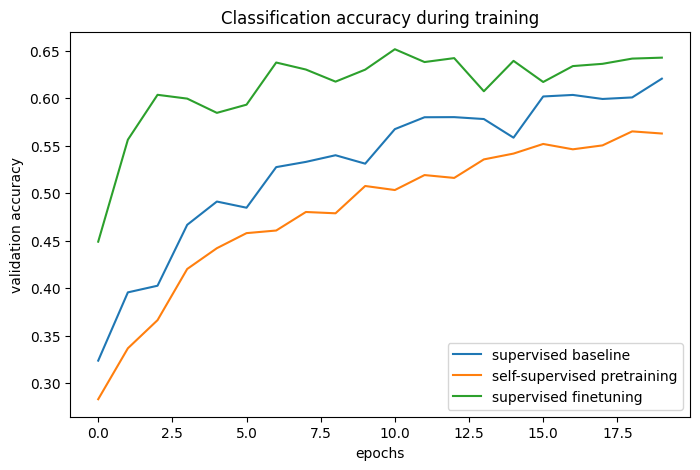

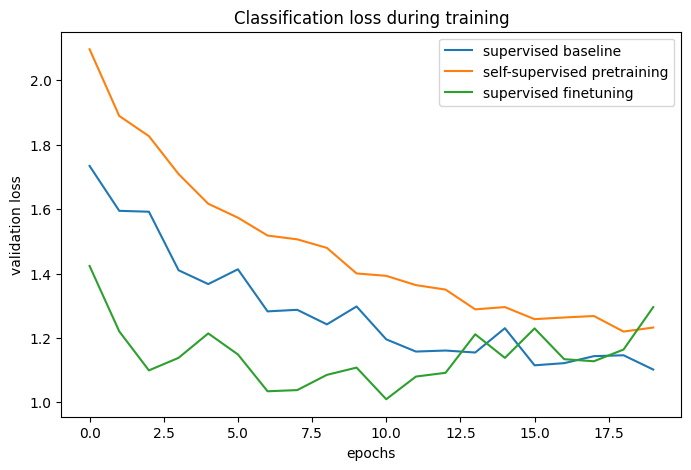

In [9]:
# The classification accuracies of the baseline and the pretraining + finetuning process:
def plot_training_curves(pretraining_history, finetuning_history, baseline_history):
    for metric_key, metric_name in zip(["acc", "loss"], ["accuracy", "loss"]):
        plt.figure(figsize=(8, 5), dpi=100)
        plt.plot(
            baseline_history.history[f"val_{metric_key}"],
            label="supervised baseline",
        )
        plt.plot(
            pretraining_history.history[f"val_p_{metric_key}"],
            label="self-supervised pretraining",
        )
        plt.plot(
            finetuning_history.history[f"val_{metric_key}"],
            label="supervised finetuning",
        )
        plt.legend()
        plt.title(f"Classification {metric_name} during training")
        plt.xlabel("epochs")
        plt.ylabel(f"validation {metric_name}")


plot_training_curves(pretraining_history, finetuning_history, baseline_history)